In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tarp import get_tarp_coverage

First, we show how to use `get_tarp_coverage` (note that this function used to be called `get_drp_coverage` in a previous version)

In [12]:
def generate_psd_matrix(n):
    # generate random array of appropriate size
    arr_size = int(n * (n - 1) / 2)
    arr = np.random.rand(arr_size)

    # convert array to symmetric matrix
    mat = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    mat[triu_indices] = arr
    mat += mat.T

    # check if matrix is positive semidefinite
    eigenvals = np.linalg.eigvalsh(mat)
    if np.all(eigenvals >= 0):
        return mat
    else:
        # if not, add identity matrix to make it PSD
        mat = mat + np.eye(n) * abs(eigenvals.min()) * 2
        return mat
    

def generate_correlated_samples(num_samples, num_sims, num_dims, covfactor=1.):
    """ Generate samples and true parameter values """
    theta = np.random.uniform(low=-5, high=5, size=(num_sims, num_dims))
    cov = [generate_psd_matrix(num_dims) for _ in range(num_sims)]
    cov = np.concatenate(cov).reshape(num_sims, num_dims, num_dims)
    samples = [np.random.multivariate_normal(mean=theta[i], cov=covfactor*cov[i], size=num_samples) for i in range(num_sims)]
    samples = np.stack(samples)
    samples = samples.transpose(1, 0, 2)
    theta = [np.random.multivariate_normal(mean=theta[i], cov=cov[i], size=1) for i in range(num_sims)]
    theta = np.stack(theta)[:,0]
    return samples, theta

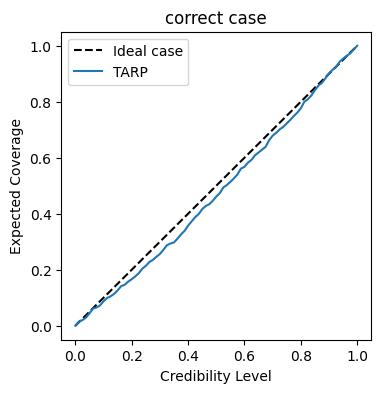

In [13]:
""" Main function """
samples, theta = generate_correlated_samples(num_samples=1000, num_sims=800, num_dims=10) # You can decrease the number of simulations for faster computation
ecp, alpha = get_tarp_coverage(samples, theta, references='random', metric='euclidean', norm = True, seed = 5)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax.plot(alpha, ecp, label='TARP')
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
ax.set_title("correct case")

plt.subplots_adjust(wspace=0.4)

In [14]:
print("correct case", np.abs(ecp - alpha).max())

correct case 0.05249999999999999


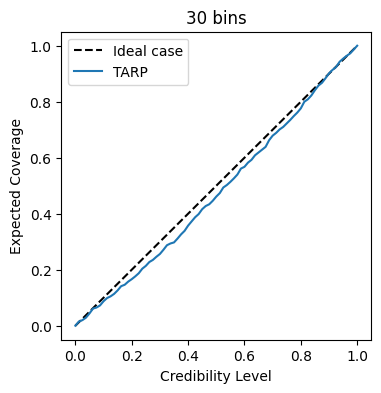

In [15]:
ecp30, alpha30 = get_tarp_coverage(samples, theta, num_alpha_bins=30,references='random', metric='euclidean', norm = True, seed = 5)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax.plot(alpha, ecp, label='TARP')
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
ax.set_title("30 bins")

plt.subplots_adjust(wspace=0.4)

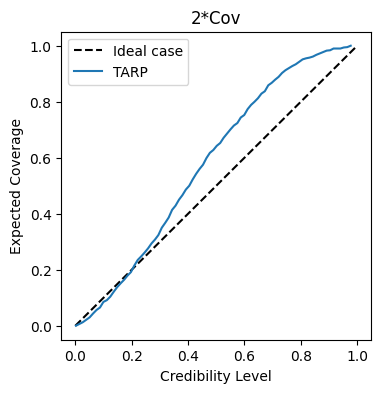

In [16]:
samples20, theta20 = generate_correlated_samples(num_samples=1000, num_sims=800, num_dims=10, covfactor=2.)
ecp20, alpha20 = get_tarp_coverage(samples20, theta20, references='random', metric='euclidean', norm = True, seed = 5)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax.plot(alpha20, ecp20, label='TARP')
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
ax.set_title("2*Cov")

plt.subplots_adjust(wspace=0.4)

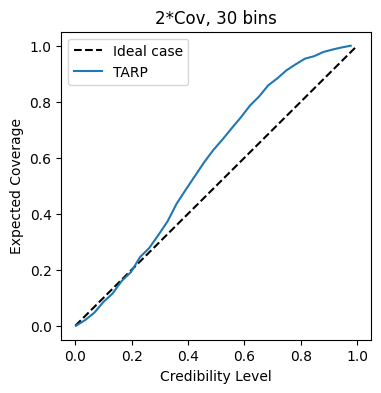

In [17]:
samples20, theta20 = generate_correlated_samples(num_samples=1000, num_sims=800, num_dims=10, covfactor=2.)
ecp20_30, alpha20_30 = get_tarp_coverage(samples20, theta20, num_alpha_bins=30, references='random', metric='euclidean', norm = True, seed = 5)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax.plot(alpha20_30, ecp20_30, label='TARP')
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
ax.set_title("2*Cov, 30 bins")

plt.subplots_adjust(wspace=0.4)

In [18]:
print("2*Cov", np.abs(ecp20 - alpha20).max())
print("2*Cov 30 bins", np.abs(ecp20_30 - alpha20_30).max())

2*Cov 0.1742499999999998
2*Cov 30 bins 0.1742499999999999


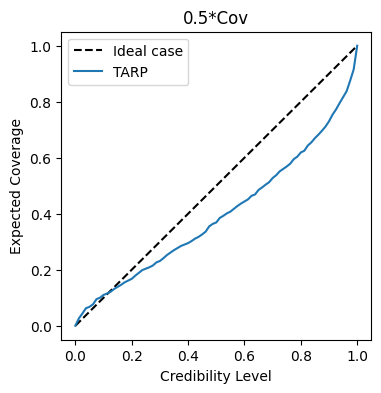

In [19]:
samples, theta = generate_correlated_samples(num_samples=1000, num_sims=800, num_dims=10, covfactor=.5)
ecp, alpha = get_tarp_coverage(samples, theta, references='random', metric='euclidean', norm = True, seed = 5)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax.plot(alpha, ecp, label='TARP')
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
ax.set_title("0.5*Cov")

plt.subplots_adjust(wspace=0.4)

In [20]:
print("0.5*Cov", np.abs(ecp - alpha).max())

0.5*Cov 0.1875


### Test bootstrapping:

The new `bootstrapping` function is now implemented for `get_tarp_coverage`. This provides a method to offset the unpredictability of each tarp test. The function `get_tarp_coverage` now has a new argument `bootstrap` which is set to `False` by default. If set to `True`, the function will return the bootstrapped coverage for each credibility level. The function will return a 2D array of shape `(num_bootstraps, num_alpha)` where `num_alpha` is the number of credibility levels. The mean and standard deviation of the bootstrapped coverage can be computed using `ecp_bootstrap.mean(axis=0)` and `ecp_bootstrap.std(axis=0)` respectively.

In [21]:
# This might take some time...
samples, theta = generate_correlated_samples(num_samples=1000, num_sims=800, num_dims=10, covfactor=1.)
ecp_bootstrap, alpha_bootstrap = get_tarp_coverage(samples, theta, references = "random", metric = "euclidean", norm = True, bootstrap=True)

samples05, theta05 = generate_correlated_samples(num_samples=1000, num_sims=800, num_dims=10, covfactor=.5)
ecp_bootstrap05, alpha_bootstrap05 = get_tarp_coverage(samples05, theta05, references = "random", metric = "euclidean", norm = True, bootstrap=True)

samples20, theta20 = generate_correlated_samples(num_samples=1000, num_sims=800, num_dims=10, covfactor=2.)
ecp_bootstrap20, alpha_bootstrap20 = get_tarp_coverage(samples20, theta20, references = "random", metric = "euclidean", norm = True, bootstrap=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.19it/s]


Text(0.5, 1.0, '2*Cov')

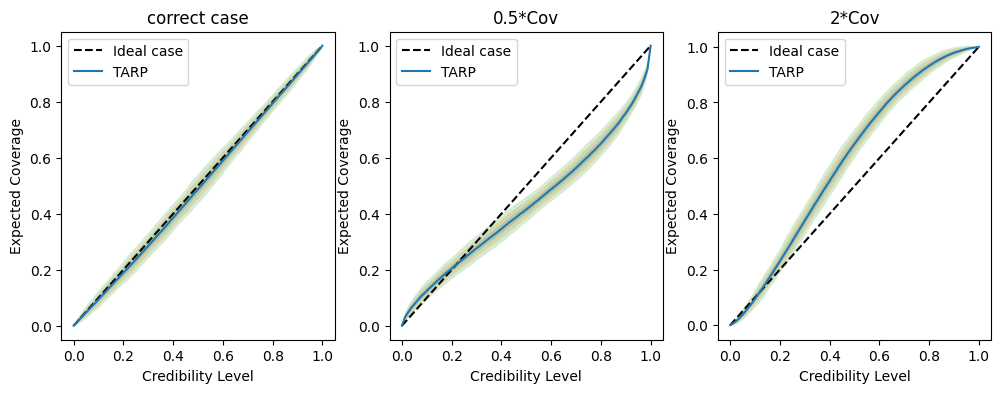

In [22]:
k_sigma = [1, 2, 3]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax[0].plot(alpha, ecp_bootstrap.mean(axis=0), label='TARP')
for k in k_sigma:
    ax[0].fill_between(alpha, ecp_bootstrap.mean(axis=0) - k * ecp_bootstrap.std(axis=0), ecp_bootstrap.mean(axis=0) + k * ecp_bootstrap.std(axis=0), alpha = 0.2)
ax[0].legend()
ax[0].set_ylabel("Expected Coverage")
ax[0].set_xlabel("Credibility Level")
ax[0].set_title("correct case")


ax[1].plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax[1].plot(alpha, ecp_bootstrap05.mean(axis=0), label='TARP')
for k in k_sigma:
    lo = ecp_bootstrap05.mean(axis=0) - k * ecp_bootstrap05.std(axis=0)
    hi = ecp_bootstrap05.mean(axis=0) + k * ecp_bootstrap05.std(axis=0)
    ax[1].fill_between(alpha, lo, hi, alpha = 0.2)
ax[1].legend()
ax[1].set_ylabel("Expected Coverage")
ax[1].set_xlabel("Credibility Level")
ax[1].set_title("0.5*Cov")

ax[2].plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax[2].plot(alpha, ecp_bootstrap20.mean(axis=0), label='TARP')
for k in k_sigma:
    lo = ecp_bootstrap20.mean(axis=0) - k * ecp_bootstrap20.std(axis=0)
    hi = ecp_bootstrap20.mean(axis=0) + k * ecp_bootstrap20.std(axis=0)
    ax[2].fill_between(alpha, lo, hi, alpha = 0.2)
ax[2].legend()
ax[2].set_ylabel("Expected Coverage")
ax[2].set_xlabel("Credibility Level")
ax[2].set_title("2*Cov")

#plt.show()